In [2]:
import requests
import json
import time
import pandas as pd
import ast
import numpy as np
import pickle

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [4]:
user_df= pd.read_csv('triplets_file.csv')
user_df.head(10000)

,user_id,song_id,listen_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1
...,...,...,...
9995,15cc706a7f24975ca831aaaf297bf0392746b3fe,SOFSETB12A8C134038,2
9996,15cc706a7f24975ca831aaaf297bf0392746b3fe,SOHIROU12AB01852AF,5
9997,15cc706a7f24975ca831aaaf297bf0392746b3fe,SOOAVGC12AB01821EC,5
9998,15cc706a7f24975ca831aaaf297bf0392746b3fe,SOPKEIV12AB018220D,5


# First 10K data from MSD and merged with Last.fm data

In [5]:
song_df= pd.read_csv('added_info.csv', index_col=0 ,dtype=object)

song_df.head()

,song_id,title,release,artist_name,year,tag,image,duration,listeners,playcount
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003,"[{'name': 'christmas', 'url': 'https://www.las...",[{'#text': 'https://lastfm.freetls.fastly.net/...,253000,1968,6601
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995,[],[{'#text': 'https://lastfm.freetls.fastly.net/...,155000,1586,4996
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006,"[{'name': 'Hip-Hop', 'url': 'https://www.last....",[{'#text': 'https://lastfm.freetls.fastly.net/...,139000,29044,116154
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003,[],[],145000,27,45
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0,[],[],NaN,NaN,NaN


In [6]:
artist_df= pd.read_csv('artists.csv', index_col=0)

In [7]:
print(user_df.shape)
print(song_df.shape)
print(artist_df.shape)

(2000000, 3)
(10000, 10)
(10000, 4)


In [8]:
user_df.isnull().sum()

user_id         0
song_id         0
listen_count    0
dtype: int64

In [9]:
song_df.isnull().sum()

song_id          0
title            0
release          0
artist_name      0
year             0
tag              0
image            0
duration       566
listeners      566
playcount      566
dtype: int64

In [10]:
artist_df.isnull().sum()

bio      0
image    0
stats    0
tags     0
dtype: int64

In [11]:
user_df.duplicated().sum()

0

In [12]:
song_df.duplicated().sum()

0

In [13]:
artist_df.duplicated().sum()

1675

In [14]:
song_df['tag'][0]

"[{'name': 'christmas', 'url': 'https://www.last.fm/tag/christmas'}, {'name': 'psychedelic', 'url': 'https://www.last.fm/tag/psychedelic'}, {'name': 'weird', 'url': 'https://www.last.fm/tag/weird'}, {'name': 'metal', 'url': 'https://www.last.fm/tag/metal'}, {'name': 'rock', 'url': 'https://www.last.fm/tag/rock'}]"

In [15]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 3 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   user_id       object
 1   song_id       object
 2   listen_count  int64 
dtypes: int64(1), object(2)
memory usage: 45.8+ MB


In [16]:
song_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   song_id      10000 non-null  object
 1   title        10000 non-null  object
 2   release      10000 non-null  object
 3   artist_name  10000 non-null  object
 4   year         10000 non-null  object
 5   tag          10000 non-null  object
 6   image        10000 non-null  object
 7   duration     9434 non-null   object
 8   listeners    9434 non-null   object
 9   playcount    9434 non-null   object
dtypes: object(10)
memory usage: 1.1+ MB


In [17]:
artist_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   bio     10000 non-null  object
 1   image   10000 non-null  object
 2   stats   10000 non-null  object
 3   tags    10000 non-null  object
dtypes: object(4)
memory usage: 390.6+ KB


In [18]:
def convert_name(text):
    L=[]
    for i in ast.literal_eval(text):
        L.append(i['name']) 
    return L 

In [19]:
song_df['tag']=song_df['tag'].apply(convert_name)

In [20]:
song_df.head()

,song_id,title,release,artist_name,year,tag,image,duration,listeners,playcount
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003,"[christmas, psychedelic, weird, metal, rock]",[{'#text': 'https://lastfm.freetls.fastly.net/...,253000,1968,6601
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995,[],[{'#text': 'https://lastfm.freetls.fastly.net/...,155000,1586,4996
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006,"[Hip-Hop, experimental, instrumental hip-hop, ...",[{'#text': 'https://lastfm.freetls.fastly.net/...,139000,29044,116154
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003,[],[],145000,27,45
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0,[],[],NaN,NaN,NaN


In [21]:
song_df['tag'][0]

['christmas', 'psychedelic', 'weird', 'metal', 'rock']

# Loading new datasets

In [22]:
user_df=pd.read_pickle('user_new.pkl')
user_df.head()

,user_id,song_id,listen_count
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
266,17aa9f6dbdf753831da8f38c71b66b64373de613,SONMWXV12AB01803B4,1
334,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOSZNRJ12A8AE46E38,6
354,5a905f000fc1ff3df7ca807d57edb608863db05d,SOAKDHD12A6310F1AE,1
397,5a905f000fc1ff3df7ca807d57edb608863db05d,SOCXGVX12A67AD85A1,1


In [195]:
song_df= pd.read_pickle('song_new.pkl')
song_df.head()

,song_id,title,release,artist_name,year,tag,duration,listeners,playcount,image_url_large,image_url_exlarge
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003,"[christmas, psychedelic, weird, metal, rock]",253000,1968,6601,https://lastfm.freetls.fastly.net/i/u/174s/a2e...,https://lastfm.freetls.fastly.net/i/u/300x300/...
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995,[],155000,1586,4996,https://lastfm.freetls.fastly.net/i/u/174s/8e4...,https://lastfm.freetls.fastly.net/i/u/300x300/...
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006,"[Hip-Hop, experimental, instrumental hip-hop, ...",139000,29044,116154,https://lastfm.freetls.fastly.net/i/u/174s/a82...,https://lastfm.freetls.fastly.net/i/u/300x300/...
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003,[],145000,27,45,n/a,n/a
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0,[],0,0,0,n/a,n/a


In [196]:
artist_df= pd.read_pickle('artist_new.pkl')
artist_df.head()

,artist_name,content,summary,artist_listeners,artist_playcount,artist_tag,artist_image_url_large,artist_image_url_exlarge
0,Faster Pussy cat,,"<a href=""https://www.last.fm/music/+noredirec...",1,2,[],,
1,Karkkiautomaatti,Karkkiautomaatti (which is 'Candy vending mach...,Karkkiautomaatti (which is 'Candy vending mach...,9727,281102,"[finnish, indie, indie pop, pop, seen live]",https://lastfm.freetls.fastly.net/i/u/174s/2a9...,https://lastfm.freetls.fastly.net/i/u/300x300/...
2,Hudson Mohawke,"Hudson Mohawke, (b. Ross Birchard), also known...","Hudson Mohawke, (b. Ross Birchard), also known...",421421,6620191,"[electronic, experimental, Hip-Hop, seen live,...",https://lastfm.freetls.fastly.net/i/u/174s/2a9...,https://lastfm.freetls.fastly.net/i/u/300x300/...
3,Yerba Brava,An argentinean cumbia villera band. Good to da...,An argentinean cumbia villera band. Good to da...,26158,169921,"[cumbia, Cumbia villera, southern elite circle...",https://lastfm.freetls.fastly.net/i/u/174s/2a9...,https://lastfm.freetls.fastly.net/i/u/300x300/...
4,Der Mystic,,"<a href=""https://www.last.fm/music/+noredirec...",2,4,[],,


In [197]:
#artist_df['content'][2]

In [25]:
print(user_df.shape)
print(song_df.shape)
print(artist_df.shape)

(20920, 3)
(10000, 11)
(10000, 8)


In [26]:
user_df.isnull().sum()

user_id         0
song_id         0
listen_count    0
dtype: int64

In [27]:
song_df.isnull().sum()

song_id              0
title                0
release              0
artist_name          0
year                 0
tag                  0
duration             0
listeners            0
playcount            0
image_url_large      0
image_url_exlarge    0
dtype: int64

In [28]:
artist_df.isnull().sum()

artist_name                 0
content                     0
summary                     0
artist_listeners            0
artist_playcount            0
artist_tag                  0
artist_image_url_large      0
artist_image_url_exlarge    0
dtype: int64

In [29]:
user_df.duplicated().sum()

0

In [30]:
song_df['song_id'].duplicated().sum()

0

In [31]:
artist_df['artist_name'].duplicated().sum()

1645

In [32]:
user_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20920 entries, 1 to 1999955
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   user_id       20920 non-null  object
 1   song_id       20920 non-null  object
 2   listen_count  20920 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 653.8+ KB


In [33]:
song_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   song_id            10000 non-null  object
 1   title              10000 non-null  object
 2   release            10000 non-null  object
 3   artist_name        10000 non-null  object
 4   year               10000 non-null  int64 
 5   tag                10000 non-null  object
 6   duration           10000 non-null  int32 
 7   listeners          10000 non-null  int32 
 8   playcount          10000 non-null  int32 
 9   image_url_large    10000 non-null  object
 10  image_url_exlarge  10000 non-null  object
dtypes: int32(3), int64(1), object(7)
memory usage: 742.3+ KB


In [34]:
artist_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   artist_name               10000 non-null  object
 1   content                   10000 non-null  object
 2   summary                   10000 non-null  object
 3   artist_listeners          10000 non-null  object
 4   artist_playcount          10000 non-null  object
 5   artist_tag                10000 non-null  object
 6   artist_image_url_large    10000 non-null  object
 7   artist_image_url_exlarge  10000 non-null  object
dtypes: object(8)
memory usage: 625.1+ KB


# Content Based Recommendation

In [35]:
#song_artist_df= song_df.merge(artist_df,on='artist_name')
#song_artist_df.head()

In [40]:
#song_df['tag']=song_df['tag'].apply(' '.join)
#song_df.head()
song_tag=[]
for _, i in song_df.iterrows():
    a=""
    for j in i['tag']:
        a= a+" "+j
    song_tag.append(a)

        
#print(song_tag)
#print(len(song_df))


#def convert_str()
    

In [200]:
song_df['text']= song_df['release']+ " " + song_df['artist_name']+ song_tag +" "+ song_df['year'].astype(str)
song_df['text']=song_df['text'].apply(lambda x:x.lower())
song_df.head()

,song_id,title,release,artist_name,year,tag,duration,listeners,playcount,image_url_large,image_url_exlarge,text
0,SOQMMHC12AB0180CB8,Silent Night,Monster Ballads X-Mas,Faster Pussy cat,2003,"[christmas, psychedelic, weird, metal, rock]",253000,1968,6601,https://lastfm.freetls.fastly.net/i/u/174s/a2e...,https://lastfm.freetls.fastly.net/i/u/300x300/...,monster ballads x-mas faster pussy cat christm...
1,SOVFVAK12A8C1350D9,Tanssi vaan,Karkuteillä,Karkkiautomaatti,1995,[],155000,1586,4996,https://lastfm.freetls.fastly.net/i/u/174s/8e4...,https://lastfm.freetls.fastly.net/i/u/300x300/...,karkuteillä karkkiautomaatti 1995
2,SOGTUKN12AB017F4F1,No One Could Ever,Butter,Hudson Mohawke,2006,"[Hip-Hop, experimental, instrumental hip-hop, ...",139000,29044,116154,https://lastfm.freetls.fastly.net/i/u/174s/a82...,https://lastfm.freetls.fastly.net/i/u/300x300/...,butter hudson mohawke hip-hop experimental ins...
3,SOBNYVR12A8C13558C,Si Vos Querés,De Culo,Yerba Brava,2003,[],145000,27,45,n/a,n/a,de culo yerba brava 2003
4,SOHSBXH12A8C13B0DF,Tangle Of Aspens,Rene Ablaze Presents Winter Sessions,Der Mystic,0,[],0,0,0,n/a,n/a,rene ablaze presents winter sessions der mystic 0


In [201]:
song_df['text'][0]

'monster ballads x-mas faster pussy cat christmas psychedelic weird metal rock 2003'

In [202]:
song_df['text'][1]

'karkuteillä karkkiautomaatti 1995'

In [203]:
#title,release,artist_name

song_new_df= song_df.drop(columns=['song_id','duration','listeners','playcount','image_url_large','image_url_exlarge','tag','release', 'artist_name','year'])
song_new_df.head()

,title,text
0,Silent Night,monster ballads x-mas faster pussy cat christm...
1,Tanssi vaan,karkuteillä karkkiautomaatti 1995
2,No One Could Ever,butter hudson mohawke hip-hop experimental ins...
3,Si Vos Querés,de culo yerba brava 2003
4,Tangle Of Aspens,rene ablaze presents winter sessions der mystic 0


# Model training

# TF-IDF

In [223]:
tfidf=TfidfVectorizer(analyzer='word' , stop_words='english')

In [224]:
vector = tfidf.fit_transform(song_new_df['text']).toarray()
vector

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [225]:
vector.shape

(10000, 18915)

In [226]:
cosine_similarities = cosine_similarity(vector) 

In [227]:
 #song_new_df[song_new_df['title'] == 'No One Could Ever'].index[0]

In [228]:
#sorted(list(enumerate(cosine_similarities[0])),reverse=True,key = lambda x: x[1])

In [229]:
#song_new_df.iloc[1].title

In [230]:
def recommend(music):
    index = song_new_df[song_new_df['title'] == music].index[0]
    distances = sorted(list(enumerate(cosine_similarities[index])),reverse=True,key = lambda x: x[1])
    for i in distances[1:6]:
        print(song_new_df.iloc[i[0]].title)
        

In [231]:
recommend('The Maestro')

Jimmy James
Don't Sweat The Technique
My Adidas
That Ain't Right
Next Levels


# Bag of Words

In [232]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features=5000,stop_words='english')

In [233]:
vector = cv.fit_transform(song_new_df['text']).toarray()

In [234]:
vector.shape

(10000, 5000)

In [235]:
cosine_similarities = cosine_similarity(vector) 

In [236]:
recommend('The Maestro')

Don't Sweat The Technique
Jimmy James
Trying To Find A Balance
My Adidas
Ancestors


# content based recommendation using KGE 

In [285]:
#embeddings= pd.read_pickle('embed_latest_20.pkl')
#embeddings.head()

,entity,embeddings
0,07dc736f3fcc5b7e5b5a0bfc50d0b19414345596,"[0.37759134, -0.3232999, -0.48396283, -0.16393..."
1,I Wouldn't Trade You For The World,"[0.51631784, -0.043912057, -0.8263092, 0.39508..."
2,f110f44e99ddd738c3e3267fed2b596bd5def300,"[0.3867665, 0.18859826, 0.25235164, -0.3090741..."
3,The Mars Volta,"[0.20633234, 0.49425384, -0.49135494, 0.520804..."
4,Skindred,"[-0.6001169, -0.43184403, 0.45567307, 0.016291..."


In [295]:
#song_kg= embeddings[embeddings['entity'].isin(song_df['title'])]
#song_kg.head()


,entity,embeddings
1,I Wouldn't Trade You For The World,"[0.51631784, -0.043912057, -0.8263092, 0.39508..."
20,Blood Money,"[-0.05760637, 1.1569898, -0.5077258, 0.7301801..."
22,28k Resolution,"[0.75442886, 0.33064696, 0.90165615, -0.464053..."
23,Settle With Me,"[0.37320563, 1.1231395, -0.40871266, 1.737954,..."
28,Bucking Retards,"[-0.4061544, 0.41902643, 0.68852794, -0.526979..."


In [298]:
#song_kg.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9777 entries, 1 to 47686
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   entity      9777 non-null   object
 1   embeddings  9777 non-null   object
dtypes: object(2)
memory usage: 229.1+ KB


In [315]:
#vector = song_kg['embeddings'].to_numpy()
#vector.shape

(9777,)

In [318]:
#cosine_sim =cosine_similarity(vector)


# Collaborative Filtering Based Recommenation

In [209]:
#user_df=pd.read_pickle('user_new.pkl')
#user_df.shape
#user_df.head()

In [204]:
user_title_df= user_df.merge(song_df,on='song_id')
user_title_df.head()

,user_id,song_id,listen_count,title,release,artist_name,year,tag,duration,listeners,playcount,image_url_large,image_url_exlarge,text
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,"[Flamenco, guitar, spanish, instrumental, guit...",0,116259,560653,n/a,n/a,flamenco para niños paco de lucia flamenco gui...
1,930d2be6c85315d72cab9823ec0f7bfe7e477794,SOBBMDR12A8C13253B,1,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,"[Flamenco, guitar, spanish, instrumental, guit...",0,116259,560653,n/a,n/a,flamenco para niños paco de lucia flamenco gui...
2,41c12ce05f18b757d9257e5ad4f8303b4b8a8758,SOBBMDR12A8C13253B,66,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,"[Flamenco, guitar, spanish, instrumental, guit...",0,116259,560653,n/a,n/a,flamenco para niños paco de lucia flamenco gui...
3,f8611810514c93d57bb846aa0b5e0410d9730a14,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,"[Flamenco, guitar, spanish, instrumental, guit...",0,116259,560653,n/a,n/a,flamenco para niños paco de lucia flamenco gui...
4,5968a59e582f434a223b3786cd51c9f4690b38d4,SOBBMDR12A8C13253B,6,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,"[Flamenco, guitar, spanish, instrumental, guit...",0,116259,560653,n/a,n/a,flamenco para niños paco de lucia flamenco gui...


In [216]:
#for export list
a=user_title_df.merge(artist_df,on='artist_name')
final=a.drop(columns=['text','user_id'])
final.tail()
#pickle.dump(final, open('final.pkl', 'wb'))

,song_id,listen_count,title,release,artist_name,year,tag,duration,listeners,playcount,image_url_large,image_url_exlarge,content,summary,artist_listeners,artist_playcount,artist_tag,artist_image_url_large,artist_image_url_exlarge
31636,SODADXS12A6D4FC0CE,1,Darlin' Do Not Fear,So Much More,Brett Dennen,2006,"[folk, acoustic, Brett Dennen, singer-songwrit...",297000,120920,361594,https://lastfm.freetls.fastly.net/i/u/174s/923...,https://lastfm.freetls.fastly.net/i/u/300x300/...,"Brett Dennen (born October 28, 1979) is a folk...","Brett Dennen (born October 28, 1979) is a folk...",762564,8209228,"[folk, singer-songwriter, acoustic, indie, Mel...",https://lastfm.freetls.fastly.net/i/u/174s/2a9...,https://lastfm.freetls.fastly.net/i/u/300x300/...
31637,SODADXS12A6D4FC0CE,2,Darlin' Do Not Fear,So Much More,Brett Dennen,2006,"[folk, acoustic, Brett Dennen, singer-songwrit...",297000,120920,361594,https://lastfm.freetls.fastly.net/i/u/174s/923...,https://lastfm.freetls.fastly.net/i/u/300x300/...,"Brett Dennen (born October 28, 1979) is a folk...","Brett Dennen (born October 28, 1979) is a folk...",762564,8209228,"[folk, singer-songwriter, acoustic, indie, Mel...",https://lastfm.freetls.fastly.net/i/u/174s/2a9...,https://lastfm.freetls.fastly.net/i/u/300x300/...
31638,SODADXS12A6D4FC0CE,6,Darlin' Do Not Fear,So Much More,Brett Dennen,2006,"[folk, acoustic, Brett Dennen, singer-songwrit...",297000,120920,361594,https://lastfm.freetls.fastly.net/i/u/174s/923...,https://lastfm.freetls.fastly.net/i/u/300x300/...,"Brett Dennen (born October 28, 1979) is a folk...","Brett Dennen (born October 28, 1979) is a folk...",762564,8209228,"[folk, singer-songwriter, acoustic, indie, Mel...",https://lastfm.freetls.fastly.net/i/u/174s/2a9...,https://lastfm.freetls.fastly.net/i/u/300x300/...
31639,SODADXS12A6D4FC0CE,20,Darlin' Do Not Fear,So Much More,Brett Dennen,2006,"[folk, acoustic, Brett Dennen, singer-songwrit...",297000,120920,361594,https://lastfm.freetls.fastly.net/i/u/174s/923...,https://lastfm.freetls.fastly.net/i/u/300x300/...,"Brett Dennen (born October 28, 1979) is a folk...","Brett Dennen (born October 28, 1979) is a folk...",762564,8209228,"[folk, singer-songwriter, acoustic, indie, Mel...",https://lastfm.freetls.fastly.net/i/u/174s/2a9...,https://lastfm.freetls.fastly.net/i/u/300x300/...
31640,SODADXS12A6D4FC0CE,1,Darlin' Do Not Fear,So Much More,Brett Dennen,2006,"[folk, acoustic, Brett Dennen, singer-songwrit...",297000,120920,361594,https://lastfm.freetls.fastly.net/i/u/174s/923...,https://lastfm.freetls.fastly.net/i/u/300x300/...,"Brett Dennen (born October 28, 1979) is a folk...","Brett Dennen (born October 28, 1979) is a folk...",762564,8209228,"[folk, singer-songwriter, acoustic, indie, Mel...",https://lastfm.freetls.fastly.net/i/u/174s/2a9...,https://lastfm.freetls.fastly.net/i/u/300x300/...


In [169]:
user_title_df= user_title_df.drop(columns=['song_id','year','tag','duration','listeners','playcount','image_url_large','image_url_exlarge','text','release','artist_name'])
user_title_df.head()
#user_title_df.shape

,user_id,listen_count,title
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,2,Entre Dos Aguas
1,930d2be6c85315d72cab9823ec0f7bfe7e477794,1,Entre Dos Aguas
2,41c12ce05f18b757d9257e5ad4f8303b4b8a8758,66,Entre Dos Aguas
3,f8611810514c93d57bb846aa0b5e0410d9730a14,2,Entre Dos Aguas
4,5968a59e582f434a223b3786cd51c9f4690b38d4,6,Entre Dos Aguas


In [170]:
#unique users
print(user_title_df['user_id'].nunique())

16233


<AxesSubplot:xlabel='user_id'>

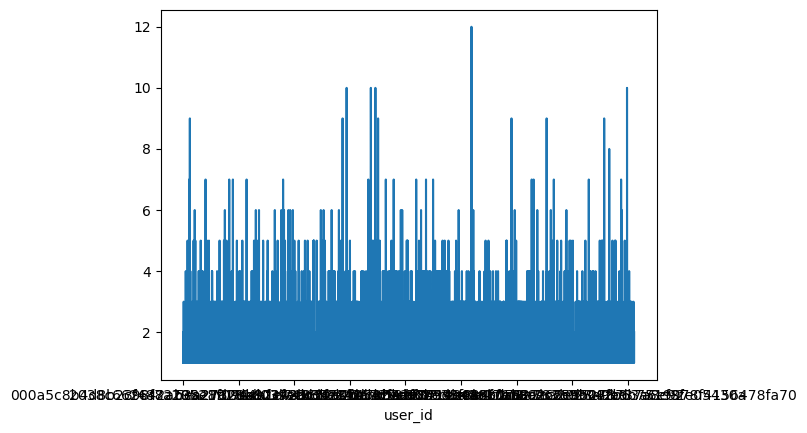

In [171]:
#
user_count=user_title_df.groupby('user_id')['listen_count'].count()
user_title_df.groupby('user_id')['listen_count'].count().plot()

In [172]:
#avearge songs listened by users
np.mean(user_count)

1.2887328281894905

In [173]:
# on an average , min and max song listened by user
print(np.median(user_count),np.min(user_count),np.max(user_count))

1.0 1 12


In [174]:
x=user_count[user_count>=3].index.to_list()
print(len(x))

862


In [175]:
regular_users=user_title_df[user_title_df['user_id'].isin(x)]
print(regular_users)

                                        user_id  listen_count  \
11     6acc0bc6f7f7c133c2d3338ade9d31f0de5115b1             4   
25     9deaca69941d7c2e3f4285d4487c05b9e86d4d20             3   
29     5a2606f54438aa88751f195382271dbb8a25c44d             3   
45     3f519b5f1c984c8d8e3eb8c1e7d047a5f9834008             2   
47     d43373d17ffa0ac21fe6b058ad3e2650f82cee48             1   
...                                         ...           ...   
20881  10d6133e0aebb2b83155b0aa17dda31fb53b286d             1   
20890  4816c80ba1a656a617303a96064582232e0edf5d             1   
20897  bbd91c4af7687524fd6decface022cf29d7f234c             1   
20904  219fa7aa1c423cfb994f1f1f2109e68d75758e1d             1   
20914  dbbfc4a77492765d183f8e952789e905068ac01e             1   

                     title  
11         Entre Dos Aguas  
25         Entre Dos Aguas  
29         Entre Dos Aguas  
45         Entre Dos Aguas  
47         Entre Dos Aguas  
...                    ...  
20881  Darlin' D

<AxesSubplot:xlabel='title'>

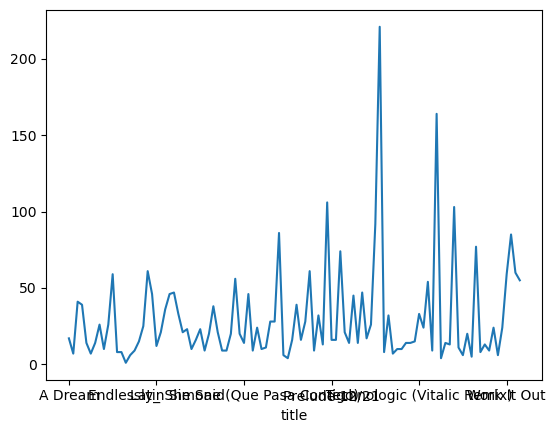

In [176]:
song_count=regular_users.groupby('title').count()['listen_count']
regular_users.groupby('title').count()['listen_count'].plot()

In [177]:
print(np.mean(song_count),np.median(song_count),np.min(song_count),np.max(song_count))

29.884615384615383 20.0 1 221


In [178]:
y=song_count[song_count>20].index.to_list()
print(len(y))

49


In [179]:
final_ratings=regular_users[regular_users['title'].isin(y)]
print(final_ratings)

                                        user_id  listen_count  \
11     6acc0bc6f7f7c133c2d3338ade9d31f0de5115b1             4   
25     9deaca69941d7c2e3f4285d4487c05b9e86d4d20             3   
29     5a2606f54438aa88751f195382271dbb8a25c44d             3   
45     3f519b5f1c984c8d8e3eb8c1e7d047a5f9834008             2   
47     d43373d17ffa0ac21fe6b058ad3e2650f82cee48             1   
...                                         ...           ...   
20817  5e955c9c5cc61457dfa0fe1c263bddcb32bd6c6f             1   
20818  d8dcabc656b20ccdf108cb8c1e092755631c601d             1   
20819  9d332bed1a8763b14883d8f268d21b154b7d40f4             2   
20821  d54da8a9619ca8219e1dfb00309b0ddc60a75879             4   
20826  1b31a3c4c5826b47ef94ffa42176df235637b5f6             2   

                      title  
11          Entre Dos Aguas  
25          Entre Dos Aguas  
29          Entre Dos Aguas  
45          Entre Dos Aguas  
47          Entre Dos Aguas  
...                     ...  
20817  Gr

In [180]:
final_user= final_ratings['user_id'].drop_duplicates()
pickle.dump(final_user, open('final_user1.pkl', 'wb'))
final_user.info()

<class 'pandas.core.series.Series'>
Int64Index: 850 entries, 11 to 20126
Series name: user_id
Non-Null Count  Dtype 
--------------  ----- 
850 non-null    object
dtypes: object(1)
memory usage: 13.3+ KB


In [214]:
#a= final_ratings['title'].drop_duplicates()
#a.head()
final_song=final_ratings['title'].drop_duplicates()
pickle.dump(final_song, open('final_song.pkl', 'wb'))
final_song.info()


<class 'pandas.core.series.Series'>
Int64Index: 49 entries, 11 to 20758
Series name: title
Non-Null Count  Dtype 
--------------  ----- 
49 non-null     object
dtypes: object(1)
memory usage: 784.0+ bytes


In [104]:
features_pt = final_ratings.pivot_table(index='title',columns='user_id',values='listen_count')

In [105]:
features_pt.fillna(0,inplace=True)

In [106]:
features_pt

user_id,00488ec44caa0d2fa669780f8cb604bf39e94392,01a41693f199fca95be1075ce352cc0c8f1878ba,01ad0fabd01af750700a1e80bb0055abcb3edd28,01b19ed1e60240dd6f0b8380340616aa41eda020,0206b1ba70a33ea6f747f30f816e07e1bb1be6b7,020edee98b8ff432f2da281aedc25356015c6f88,027a6479fc5b17468cc600d50a1e419ca181eb4e,02cc2d0009ebdcc23537d9e99cb8a823cc77ef8a,02d91ab8041be53d29b114615241c47834cf5276,032c5868a0d2be985db65de6b4b5810db9af0bf7,...,fc3360c5a95f851785240111560e0fa266928fea,fc993f1ac6cd0705aed8949edf15e505e1eb5819,fd058134a3023fa23fc0bf06e76a1707824170e3,fd1f275f7c4f69a015ffa07039df35e6621020b0,fd4acfa1b7d6a050e9526a59e913f6879a68f481,fd55b4fbea13bf9fe665380465480465e1680914,fdc980a3ef5f1d08575f90899b8145b20fb3181e,fe1aca4da5ed0844dac5ec17098555e5bcc002a9,fe967f20b8f77f104ab6e03c5714723e1cb3376e,ff75f58dff87e9f9f767134882e515e75cd94dde
title,,,,,,,,,,,,,,,,,,,,,
All Men Are Liars,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Alley Oop (Girls Version) (2007 Digital Remaster),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Big Yellow Taxi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Bullet Tells The Truth,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Burnin' Up,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Don't Walk Away,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
Drunk and Hot Girls,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
East Man Skank,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Entre Dos Aguas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [107]:
features_pt.index[2]

'Big Yellow Taxi'

In [108]:
from scipy.sparse import csr_matrix
rating_matrix= csr_matrix(features_pt.values)


In [109]:
#uniques_song_df = user_df.drop_duplicates(['userID', 'bookTitle'])

# KNN recommender

In [110]:
from sklearn.neighbors import NearestNeighbors


In [111]:
model_knn =NearestNeighbors(metric='cosine' , algorithm='brute')

In [112]:
model_knn.fit(rating_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [238]:
#query_index = np.random.choice(features_pt.shape[0])
#print(query_index)
#distances, indices = model_knn.kneighbors(features_pt.iloc[query_index,:].values.reshape(1,-1), n_neighbors = 6)
#print(distances, indices)

In [114]:
#features_pt.iloc[query_index,:].values.reshape(1,-1)

In [115]:
#features_pt.index[query_index]

'Money (featuring Gary "Nesta" Pine & Dollarman)'

In [239]:
#for i in range(0, len(distances.flatten())):
 #   if i == 0:
  #      print('Recommendations for {0}:\n'.format(features_pt.index[query_index]))
  #  else:
 #       print('{0}: {1}, with distance of {2}:'.format(i, features_pt.index[indices.flatten()[i]], distances.flatten()[i]))

In [219]:
def recommend_knn(music):
    # index fetch
    index= features_pt.index.to_list().index(music)   
    distances, indices = model_knn.kneighbors(features_pt.iloc[index,:].values.reshape(1,-1), n_neighbors = 6) 
    #distances = sorted(list(enumerate(cosine_similarities[index])),reverse=True,key = lambda x: x[1])
    for i in range(0, len(distances.flatten())):
        if i == 0:
            print('Recommendations for {0}:\n'.format(features_pt.index[index]))
        else:
            print('{0}: {1}, with distance of {2}:'.format(i, features_pt.index[indices.flatten()[i]], distances.flatten()[i]))
        #print(song_new_df.iloc[i[0]].title)

In [237]:
recommend_knn('The Maestro')

Recommendations for The Maestro:

1: All Men Are Liars, with distance of 0.838317996320316:
2: Sincerité Et Jalousie, with distance of 0.8603959348142286:
3: Relegate the Judge, with distance of 0.8646133583619875:
4: Porno Disaster, with distance of 0.8648108590384551:
5: Rage!, with distance of 0.9029635824172096:


In [282]:
#a=song_df[song_df['title'] == 'No One Could Ever']
#print(a)

              song_id              title release     artist_name  year  \
2  SOGTUKN12AB017F4F1  No One Could Ever  Butter  Hudson Mohawke  2006   

                                                 tag  duration  listeners  \
2  [Hip-Hop, experimental, instrumental hip-hop, ...    139000      29044   

   playcount                                    image_url_large  \
2     116154  https://lastfm.freetls.fastly.net/i/u/174s/a82...   

                                   image_url_exlarge  \
2  https://lastfm.freetls.fastly.net/i/u/300x300/...   

                                                text  
2  butter hudson mohawke hip-hop experimental ins...  


In [252]:
#len(song_df['song_id'])

10000

In [314]:
#features_pt.index.to_list()

['SOAKDHD12A6310F1AE',
 'SOBOUPA12A6D4F81F1',
 'SOCIUSI12AB018DD03',
 'SOCXGVX12A67AD85A1',
 'SOEDGBE12A670211D3',
 'SOESZWS12A6D4F910C',
 'SOETSTN12A81C219A9',
 'SOFRZBI12A8C145A85',
 'SOGKGLB12A81C22AFA',
 'SOGLBQA12A6701E7AF',
 'SOHILNH12A6701E1C3',
 'SOHTLBP12A8C1360DD',
 'SOKZRTZ12A6D4F619C',
 'SOLLWCK12A6D4FB0B9',
 'SOLPVAQ12AB017EB35',
 'SOMMONH12A6D4F41CD',
 'SOMTVRZ12A8C13A987',
 'SONDUKG12A58A7DA36',
 'SONMWXV12AB01803B4',
 'SOOZADV12AF729E506',
 'SOPDTVU12AB018D1B4',
 'SOPKTEV12A8C141E33',
 'SOPXGQV12A58A7C985',
 'SOQISNQ12A8AE45F4C',
 'SOQRZNB12AB0184CF6',
 'SORVHGJ12AB01883C4',
 'SOTGKTG12AB0189D2E',
 'SOUEGBF12AB017EFD5',
 'SOUTGUB12AB017DC5B',
 'SOWEWCO12A8C14074E',
 'SOWKLEE12A81C232AC',
 'SOXZSEH12AC468CABB']

In [394]:
#features_pt.shape[0]

32

In [411]:
#features_pt.index[0]

'All Men Are Liars'

In [400]:
#len(distances.flatten())

6

In [255]:
#features_pt.index.to_list().index("All Men Are Liars")

2